In [18]:
import sys
import math
from collections import namedtuple, defaultdict

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter

import gym_atena.envs.atena_env_cont as atena_env_cont
from gym_atena.envs.atena_env_cont import ATENAEnvCont
import Configuration.config as cfg
%matplotlib inline

# Compaction Gain

In [19]:
def numerically_stable_normalized_sigmoid(a,b, x):
    """Numerically stable sigmoid function.
    
    based on code from https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    """
    
    if b*(x-a) < 0:
        z = math.exp(b*(x-a))
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = math.exp(b*(-x+a))
        return z / (1 + z)
def normalized_sigmoid_fkt(a, b, x):
    """
    Returns array of a horizontal mirrored normalized sigmoid function
    output between 0 and 1
    Function parameters a = center; b = width
    To get a numerically stable implementation use from 'scipy.special import expit' as explained here
    https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python
    """
    #return 1/(1+math.exp(b*(x-a)))
    return numerically_stable_normalized_sigmoid(a,b,x)




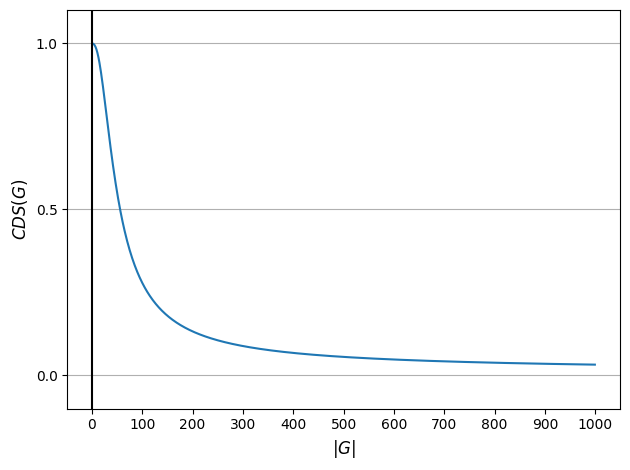

In [20]:
def compaction_display_score(G, denominator_epsilon=0.00001):
    return normalized_sigmoid_fkt(0.5, 17, 1 - 1 / math.log(8 + G + denominator_epsilon, 8))

max_G = 1000
Gs = np.arange(1, max_G, 1)
compaction_display_score_Gs = np.array([compaction_display_score(G) for G in range(1,max_G)])

plt.plot(Gs, compaction_display_score_Gs)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$|G|$', size=12)
plt.ylabel('$CDS(G)$', size=12)

# x axis ticks
plt.xticks([x*100 for x in range(11)])

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

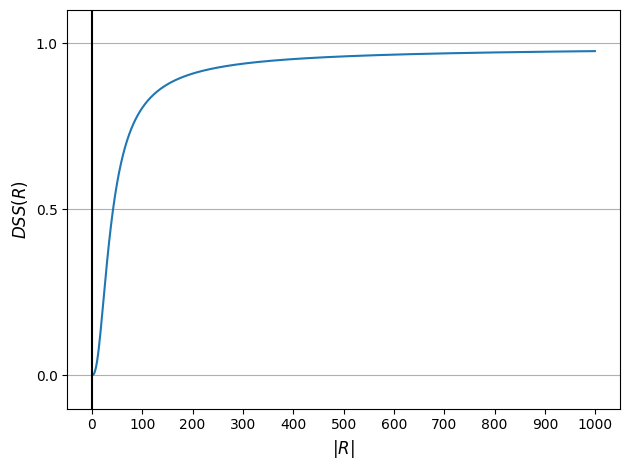

In [21]:
def data_size_score(R, denominator_epsilon=0.00001):
    return 1-normalized_sigmoid_fkt(0.5, 17, 1 - 1 / math.log(7 + R + denominator_epsilon, 7))

max_R = 1000
Rs = np.arange(1, max_R, 1)
data_size_score_Rs = np.array([data_size_score(R) for R in range(1,max_R)])

plt.plot(Rs, data_size_score_Rs)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$|R|$', size=12)
plt.ylabel('$DSS(R)$', size=12)

# x axis ticks
plt.xticks([x*100 for x in range(11)])

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def compaction_gain(G,R, denominator_epsilon=0.00001):
    return data_size_score(R) * compaction_display_score(G)

def compaction_gain_no_sigmoid(G,R, denominator_epsilon=0.00001):
    return R / (G + denominator_epsilon)

def plot_compaction_gain(G, R, sigmoid=True):
    """
    sigmoid: If True sigmoid is being used both for G and R, else,
    R and G are used as is (with a linear effect)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Make data.
    X = np.arange(1, G, 1)
    Y = np.arange(1, R, 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X, dtype=np.float32)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if sigmoid:
                Z[i,j]=compaction_gain(X[i,j], Y[i,j])
            else:
                Z[i,j]=compaction_gain_no_sigmoid(X[i,j], Y[i,j])

            #print("i={}, j={}, X[i,j]={}, Y[i,j]={}, Z[i,j]={}".format(i,j, X[i,j], Y[i,j], Z[i,j]))
    #print(X)
    #print(Y)
    #print(Z)
    #print(readability_gain(1,100))

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # axis labels
    ax.set_xlabel("Number groups")
    ax.set_ylabel("Number of rows")
    ax.set_zlabel("Compaction gain")

    # Customize the z axis.
    if sigmoid:
        ax.set_zlim(-0.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Set figure size
    fig.set_size_inches(16.5, 9.0)

    plt.show()

## With sigmoid

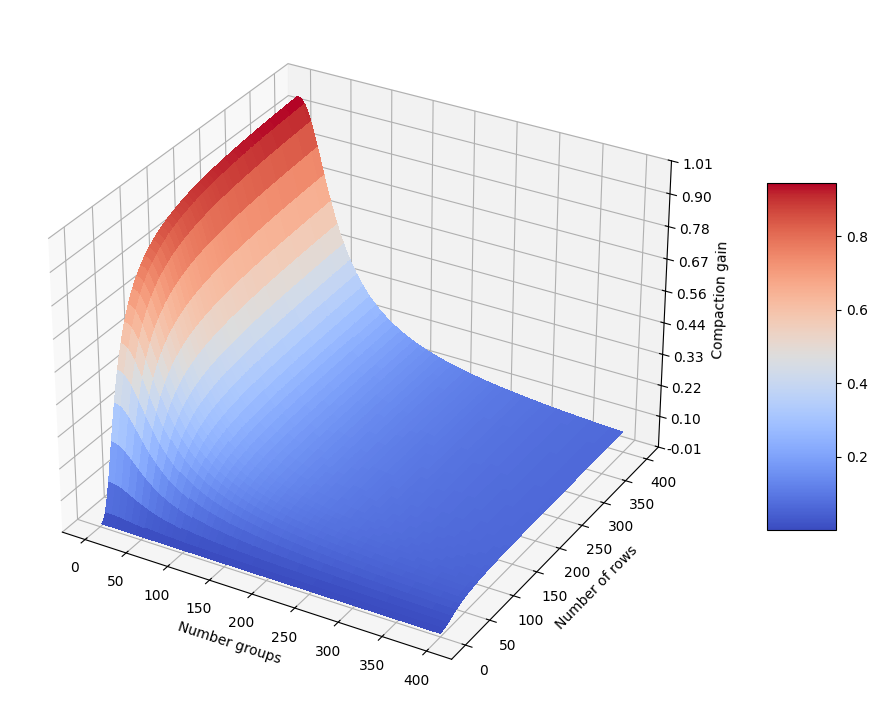

In [26]:
plot_compaction_gain(400, 400)

## Without sigmoid

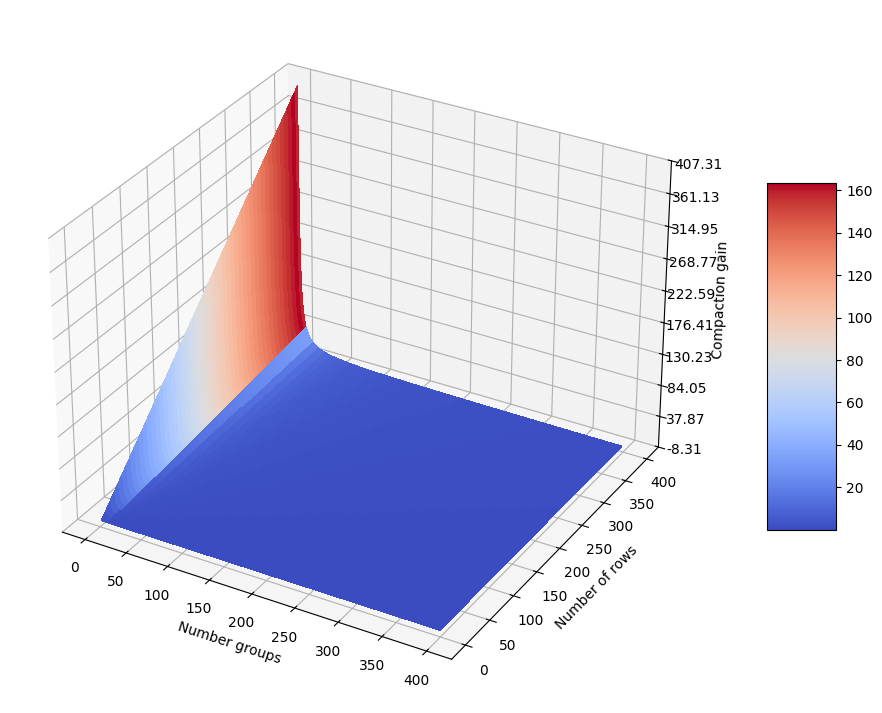

In [27]:
plot_compaction_gain(400, 400, sigmoid=False)

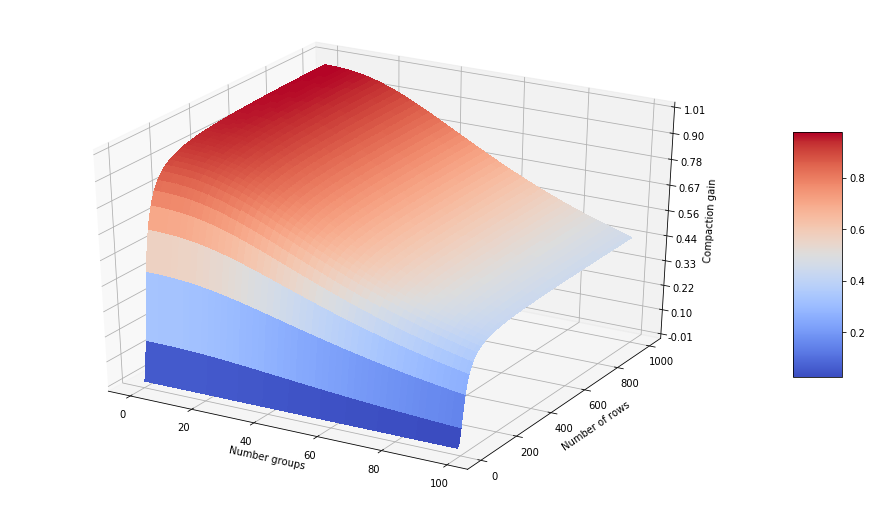

In [14]:
plot_compaction_gain(100, 1000)

# Deviation-Based (KL Diveregence) Reward

In [28]:
def deviation_based(kl_div, sigmoid=True):
    if sigmoid:
        return 1 / (1 + math.exp(-(kl_div / 2 - 3)))
    else:
        return kl_div
    
def plot_deviation_based(sigmoid=True):
    max_kl_div = 50
    kl_divs = np.arange(0, max_kl_div, 1)
    deviation = np.array([deviation_based(kl_div, sigmoid=sigmoid) for kl_div in range(0,max_kl_div)])

    plt.plot(kl_divs, deviation)
    plt.axvline(0.0, color='k')
    if sigmoid:
        plt.ylim(-0.1, 1.1)
    plt.xlabel('$\max{(D_{KL})}$', size=12)
    plt.ylabel('$I_{KL}$', size=12)

    # x axis ticks
    #plt.xticks([x*100 for x in range(11)])

    # y axis ticks and gridline
    if sigmoid:
        plt.yticks([0.0, 0.5, 1.0])
    ax = plt.gca()
    ax.yaxis.grid(True)


    plt.tight_layout()
    plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/nq/v_7l2dgx4m301tz6hhh7wz7h0000gn/T/ipykernel_69807/3201500681.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\max{(D_{KL})}$', size=12)


## with sigmoid

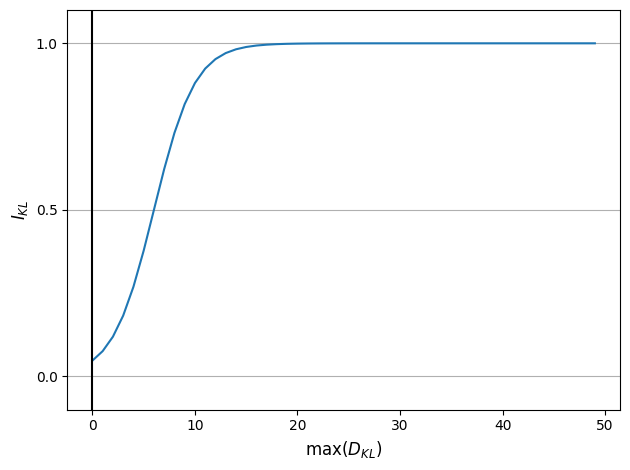

In [29]:
plot_deviation_based()

## without sigmoid

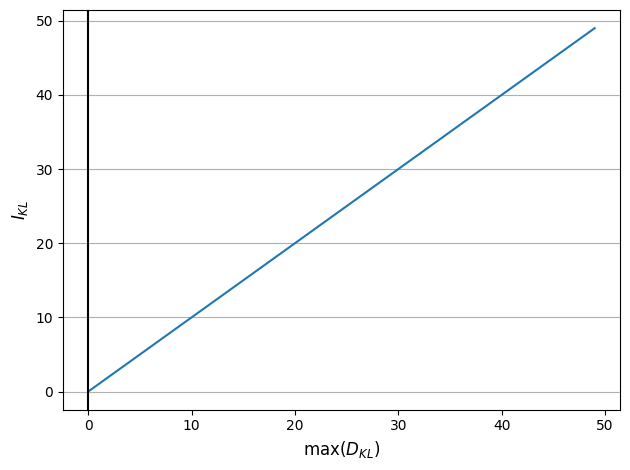

In [30]:
plot_deviation_based(sigmoid=False)

# Distribution of KL reward

In [32]:
%%capture

kl_rewards_actions_all = []
kl_rewards_all = []
# filter only (no group)
cfg.arch = 'FF_PARAM_SOFTMAX'
actions_lst = []
for filter_action in range(1,397):
    actions_lst.append(filter_action)
    actions_lst.append(0)  #  back
for dataset_number in range(4):
    kl_rewards_actions = []
    kl_rewards = []
    info_hist, r = ATENAEnvCont.debug_actions(actions_lst, dataset_number, compressed=False, filter_by_field=True, continuous_filter_term=True,
                       displays=True,
                       kl_coeff=1.0,
                       compaction_coeff=1.0,
                       diversity_coeff=1.0,
                       humanity_coeff=1.0,
                       )
    for i, (info, r) in enumerate(info_hist):
        if i % 2 == 0:
            kl_reward = info["reward_info"].kl_distance
            if kl_reward != 0:
                kl_rewards_actions.append((info["action"], info["reward_info"].kl_distance))
                kl_rewards.append(info["reward_info"].kl_distance)
    kl_rewards_actions_all.append(kl_rewards_actions)
    kl_rewards_all.append(kl_rewards)
    

In [33]:
if False:
    import os
    for i in range(4):
        df = pd.DataFrame({'kl_reward': kl_rewards_all[i]})
        df.to_csv(os.path.join('/home/oribarel/Dropbox/atena_sigmod/kl_reward_distribution/with_sigmoid/csv/networking',
                               f'dataset{i}.csv'))


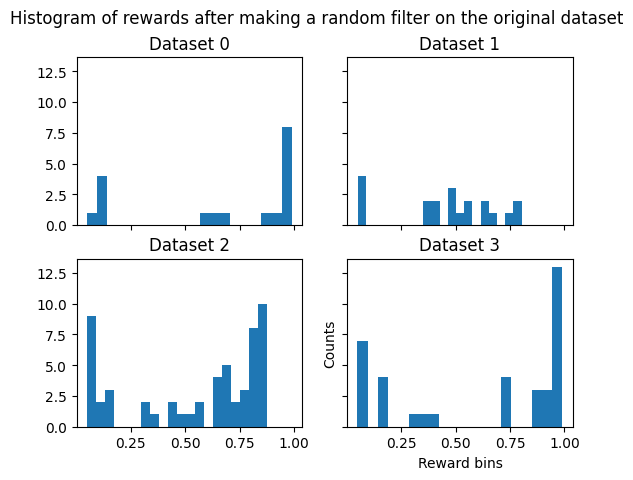

In [34]:
n_bins = 20

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

# We can set the number of bins with the `bins` kwarg
axs[0, 0].hist(kl_rewards_all[0], bins=n_bins)
axs[0, 1].hist(kl_rewards_all[1], bins=n_bins)
axs[1, 0].hist(kl_rewards_all[2], bins=n_bins)
axs[1, 1].hist(kl_rewards_all[3], bins=n_bins)
axs[0, 0].set_title("Dataset 0")
axs[0, 1].set_title("Dataset 1")
axs[1, 0].set_title("Dataset 2")
axs[1, 1].set_title("Dataset 3")
fig.suptitle('Histogram of rewards after making a random filter on the original dataset')
plt.xlabel('Reward bins')
plt.ylabel('Counts')
plt.show()


In [35]:
kl_rewards_actions_all[2]

[("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '01:00:5e:00:00:16'",
  0.7915449522096298),
 ("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '08:00:27:cd:3d:55'",
  0.8029880958540069),
 ("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '08:00:27:91:fd:44'",
  0.8624708816659157),
 ("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '08:00:27:ba:0b:03'",
  0.8387590847532594),
 ("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '08:00:27:a1:5f:bf'",
  0.8065082697472391),
 ("Filter on Column 'eth_dst', using condition '<built-in function eq>', with term '52:54:00:12:35:02'",
  0.6751181624431357),
 ("Filter on Column 'eth_dst', using condition '<built-in function ne>', with term '01:00:5e:00:00:16'",
  0.04973255044346919),
 ("Filter on Column 'eth_dst', using condition '<built-in function ne>', with term '08:00:27:cd:3d:55'"

# back_as_a_function_of_stacked_non_backs = 1 - 2 / (2 ** num_of_stacked_non_back_actions - 1 + 0.1)

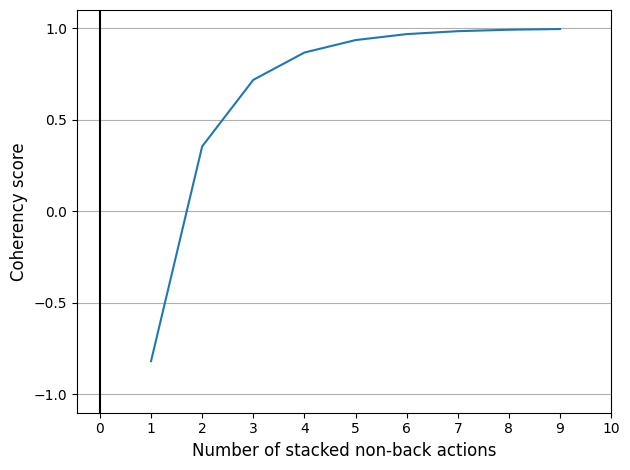

In [36]:
def back_as_a_function_of_stacked_non_backs(num_of_stacked_non_back_actions):
    return 1 - 2 / (2 ** num_of_stacked_non_back_actions - 1 + 0.1)


max_num_of_stacked_non_back_actions = 10
nums_of_stacked_non_back_actions= np.arange(1, max_num_of_stacked_non_back_actions, 1)
back_score = np.array(
    [back_as_a_function_of_stacked_non_backs(
        num_of_stacked_non_back_actions) for num_of_stacked_non_back_actions in range(
        1,max_num_of_stacked_non_back_actions)
    ]
)

plt.plot(nums_of_stacked_non_back_actions, back_score)
plt.axvline(0.0, color='k')
plt.ylim(-1.1, 1.1)
plt.xlabel('Number of stacked non-back actions', size=12)
plt.ylabel('Coherency score', size=12)

# x axis ticks
plt.xticks([x for x in range(11)])

# y axis ticks and gridline
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

# back_after_filter_readability_gain

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def readability_gain(disp_rows_prev,disp_rows_prev_prev, denominator_epsilon=0.00001):
    prev_readability = normalized_sigmoid_fkt(
        0.5, 17, 1 - 1 / math.log(10 + disp_rows_prev + denominator_epsilon, 10))
    prev_prev_readability = normalized_sigmoid_fkt(
        0.5, 17, 1 - 1 / math.log(10 + disp_rows_prev_prev + denominator_epsilon, 10))
    #assert prev_readability >= prev_prev_readability

    readability_gain = 1 - prev_prev_readability / prev_readability
    # transforming the readability gain to be in tange [-1.0, 1.0]
    normalized_readability_gain = -1 + 2 * normalized_sigmoid_fkt(
        0.6, 11, 1 - readability_gain*prev_readability)
    return normalized_readability_gain

def plot_readability_gain(disp_rows_prev,disp_rows_prev_prev, denominator_epsilon=0.00001):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Make data.
    X = np.arange(0, disp_rows_prev, 1)
    Y = np.arange(0, disp_rows_prev_prev, 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X, dtype=np.float32)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i,j]=readability_gain(X[i,j], Y[i,j])
            #print("i={}, j={}, X[i,j]={}, Y[i,j]={}, Z[i,j]={}".format(i,j, X[i,j], Y[i,j], Z[i,j]))
    #print(X)
    #print(Y)
    #print(Z)
    #print(readability_gain(1,100))

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # axis labels
    ax.set_xlabel("Number of rows / groups after filter")
    ax.set_ylabel("Number of rows / groups before filter")
    ax.set_zlabel("Normalized readability gain")

    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Set figure size
    fig.set_size_inches(16.5, 9.0)

    plt.show()

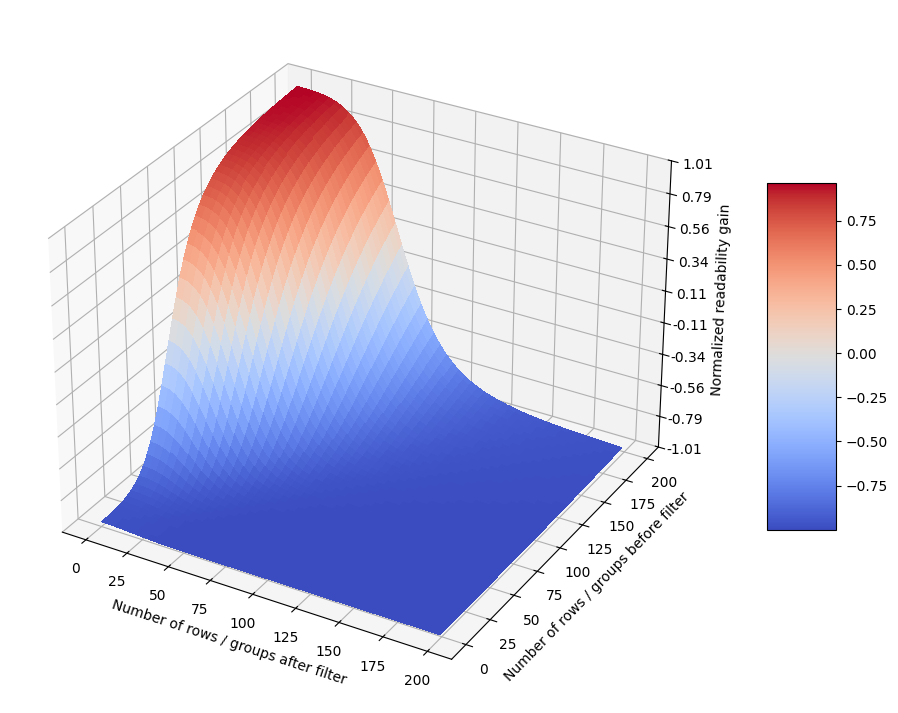

In [38]:
plot_readability_gain(200, 200)

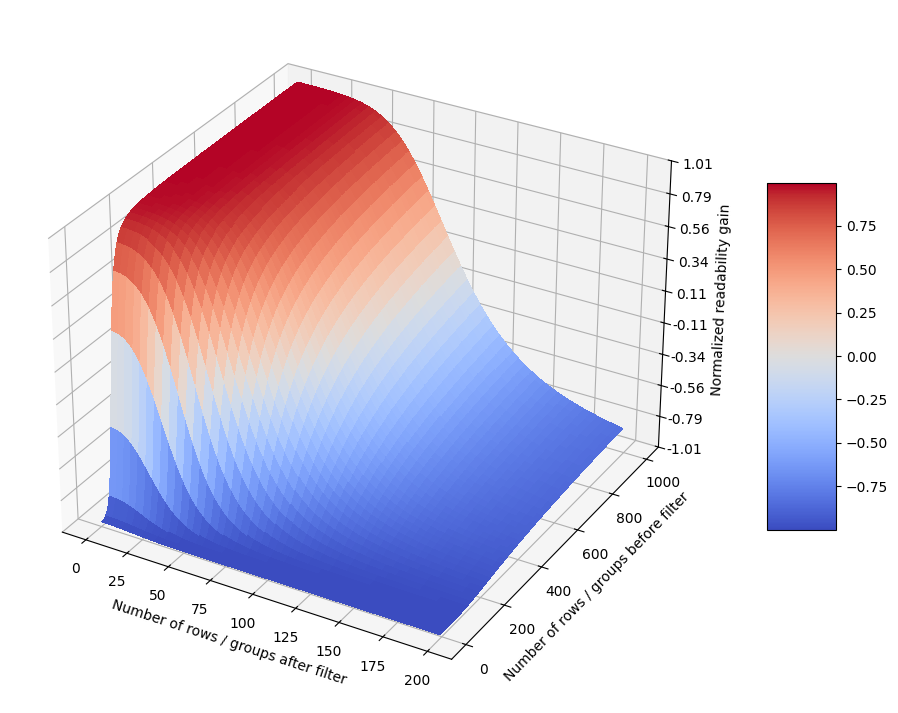

In [39]:
plot_readability_gain(200, 1000)

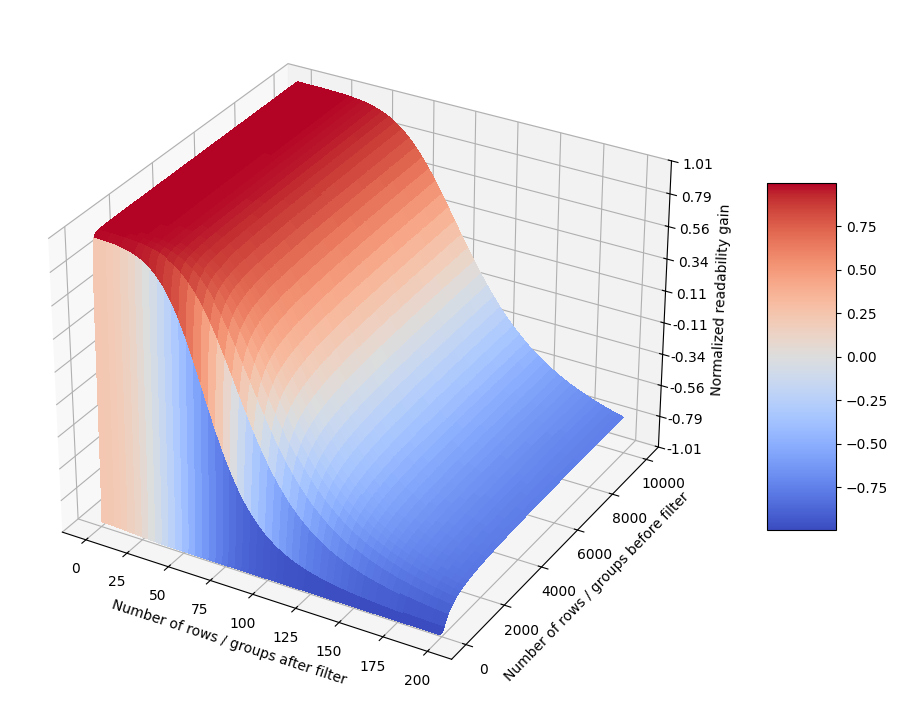

In [40]:
plot_readability_gain(200, 10000)